In [1]:
from typing import List

import pandas as pd
from pandas import DataFrame

RANDOM_STATE = 111

dataframe = pd.read_csv("data.csv", header=0)
dataframe.loc[dataframe["y"] < 50, "y"] = 1
dataframe.loc[dataframe["y"] >= 50, "y"] = 0

In [2]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import KMeansSMOTE
from sklearn.preprocessing import StandardScaler


def get_keys(df: DataFrame) -> List[str]:
    result = []

    for col in df.columns:
        result.append(col)

    result.remove("y")
    return result


def get_train_val(x_data, y_data):
    return train_test_split(x_data, y_data, test_size=0.2, random_state=RANDOM_STATE, stratify=y_data)


def get_train_val_split(x_data, y_data):
    return train_test_split(x_data, y_data, test_size=0.25, random_state=RANDOM_STATE, stratify=y_data)


def remove_outliers(x_data, y_data):
    pca = PCA(n_components=3, random_state=RANDOM_STATE)
    all_pca = pca.fit_transform(x_data)

    mask = []

    for idx, unit in enumerate(all_pca):
        x = unit[0]
        y = unit[1]
        z = unit[2]

        if x > 500:
            continue
        elif y > 100:
            continue
        elif z > 40:
            continue

        mask.append(idx)

    return x_data.loc[mask, :], y_data.loc[mask]


keys = get_keys(dataframe)
X_all = dataframe[keys]
y_all = dataframe["y"]
X_all, y_all = remove_outliers(X_all, y_all)
X_train, X_test, y_train, y_test = get_train_val(X_all, y_all)
X_train, X_val, y_train, y_val = get_train_val_split(X_train, y_train)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

smote = KMeansSMOTE(cluster_balance_threshold=0.1, random_state=RANDOM_STATE)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [3]:
import matplotlib.pyplot as plt


def plot_dataset(x_data, y_data):
    pca = PCA(n_components=3)
    all_pca = pca.fit_transform(x_data)
    all_label = y_data
    colors = []

    for label in all_label:
        if label == 1:
            colors.append("red")
        else:
            colors.append("blue")

    x_plt = []
    y_plt = []
    z_plt = []

    for unit in all_pca:
        x_plt.append(unit[0])
        y_plt.append(unit[1])
        z_plt.append(unit[2])

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x_plt, y_plt, z_plt, c=colors)
    plt.gca().view_init(20, -70)
    plt.show()

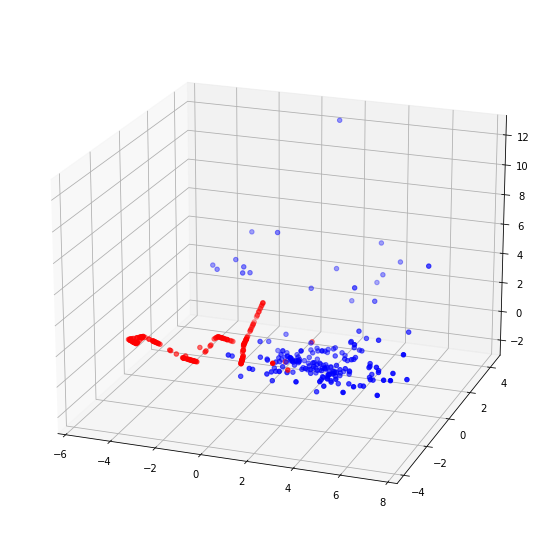

In [4]:
plot_dataset(X_train, y_train)

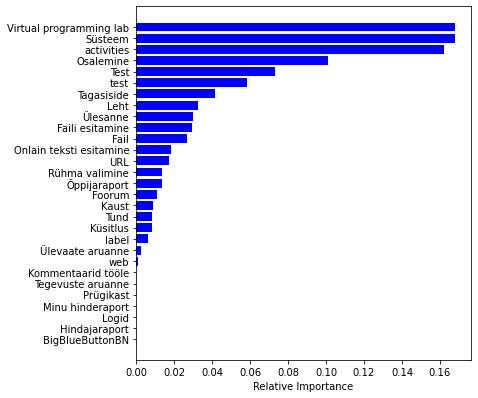

In [5]:
from typing import List

import numpy as np
from sklearn.ensemble import RandomForestClassifier


def plot_feature_importances() -> List[str]:
    y = []
    results = []
    i = 0
    feature_names = dataframe.columns[:-1]

    forest = RandomForestClassifier(random_state=RANDOM_STATE)
    forest.fit(X_train, y_train)

    for imt in forest.feature_importances_:
        imt = round(imt,4)
        results.append((feature_names[i], imt))
        i = i + 1

    results.sort(key=lambda importance: importance[1])
    results.reverse()

    importances = forest.feature_importances_
    indices = np.argsort(importances)
    plt.figure(figsize=(6, 6.5))
    plt.barh(range(len(indices)), importances[indices], color="b", align="center")

    for s in results:
        y.append(s[0])

    y.reverse()
    plt.yticks(np.arange(len(y)), y)
    plt.xlabel("Relative Importance")
    plt.show()

    return y

features = plot_feature_importances()
features.reverse()
selected_feature = features[:19]

In [6]:
from sklearn.svm import SVC

X_train = DataFrame(X_train)
X_train.columns = keys
X_val = DataFrame(X_val)
X_val.columns = keys

model = SVC(random_state=RANDOM_STATE)
model.fit(X_train[selected_feature], y_train)
y_pred = model.predict(X_val[selected_feature])

print(f"Accuracy {np.sum(y_pred == y_val) / len(y_pred) * 100:.2f}%")
print(f"Recall rate {(np.sum(y_pred == 1) / np.sum(y_val == 1)) * 100:.2f}%")

Accuracy 91.18%
Recall rate 100.00%


In [7]:
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold

X_all = dataframe[keys]
y_all = dataframe["y"]
X_all, y_all = remove_outliers(X_all, y_all)
X_train, _, y_train, _ = get_train_val(X_all, y_all)
X_train = X_train[selected_feature]

kf = RepeatedStratifiedKFold(n_splits=4, n_repeats=20, random_state=RANDOM_STATE)
imba_pipeline = make_pipeline(
        StandardScaler(),    # noqa
        KMeansSMOTE(cluster_balance_threshold=0.1, random_state=RANDOM_STATE),    # noqa
        SVC(random_state=RANDOM_STATE)    # noqa
)

scoring = ["accuracy", "recall"]
cv_results = cross_validate(imba_pipeline, X_train, y_train, cv=kf, scoring=scoring)
print(f"CV Accuracy: {cv_results['test_accuracy'].mean() * 100:.2f}%")
print(f"CV Recall: {cv_results['test_recall'].mean() * 100:.2f}%")

CV Accuracy: 93.19%
CV Recall: 50.21%
